<h1> Prediksi Pengisian Ulang Produk Berbasis Pengguna Berdasarkan Pesanan Historis dan Fitur Item </h1>


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1.Import Dataset

In [ ]:
!gdown --id 1FF3yQs2ARKfjdTqqhObFIsubqVEVf70h
!gdown --id 1o_CWlQlICQlTWid-OcYit5-i63zy4GPU
!gdown --id 1rstjZ3eEuc3Hs44-njVtaUBj3auHZiH0
!gdown --id 1XXMe4YaTBhfdJSOhKTpyjnQqn1RFnYwJ

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1FF3yQs2ARKfjdTqqhObFIsubqVEVf70h
To: /content/category_hierarchy.csv
100% 41.2k/41.2k [00:00<00:00, 32.8MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1o_CWlQlICQlTWid-OcYit5-i63zy4GPU
To: /content/items.csv
100% 1.28M/1.28M [00:00<00:00, 102MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
F

In [ ]:
df_orders = pd.read_csv("orders.csv", sep = "|")
df_items = pd.read_csv("items.csv", sep = "|")
df_hierarchy = pd.read_csv("category_hierarchy.csv", sep = "|")
df_submission = pd.read_csv("submission.csv", sep = "|")

1. Data items (items.csv) adalah kumpulan data yang mengandung karakteristik dari setiap item yang dijual berupa kolom-kolom yang merepresentasikan fitur dari suatu item. 
2. Data orders (orders.csv) merupakan data yang berisikan informasi tentang pesanan pengguna selama delapan bulan. Setiap baris menampilkan satu transaksi untuk satu item tunggal dari periode tanggal 1 Juni 2020 - 31 Januari 2021.
3. Data category hierarchy (category_hierarchy.csv) adalah data yang berisi dua kolom kategori yang telah di-encode, yang memetakan setiap kategori ke kategori induknya.
4. Data submission (submission.csv) adalah dataset untuk pengumpulan dan berisi subset kombinasi userID dan itemID yang telah ditentukan sebelumnya serta kolom "prediksi" untuk memprediksi apakah suatu barang diisi ulang pada minggu tertentu pada periode (bulan berikutnya) tanggal 1 Februari 2021 - 28 Februari 2021


# 2.Analisis Data

## 2.1.Informasi Kolom Data

In [ ]:
# Preview dataset
df_orders

,date,userID,itemID,order
0,2020-06-01,38769,3477,1
1,2020-06-01,42535,30474,1
2,2020-06-01,42535,15833,1
3,2020-06-01,42535,20131,1
4,2020-06-01,42535,4325,1
...,...,...,...,...
1071533,2021-01-31,22114,29567,2
1071534,2021-01-31,22114,21068,1
1071535,2021-01-31,10900,18270,1
1071536,2021-01-31,17894,31265,5


In [ ]:
# dataset info
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071538 entries, 0 to 1071537
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   date    1071538 non-null  object
 1   userID  1071538 non-null  int64 
 2   itemID  1071538 non-null  int64 
 3   order   1071538 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 32.7+ MB


In [ ]:
# Mengecek nilai yang hilang pada tiap kolom
df_orders.isna().sum()

date      0
userID    0
itemID    0
order     0
dtype: int64

## 2.2.Jumlah Order Barang Perbulan

In [ ]:
# Convert tipe data pada kolom date
df_orders['date'] = pd.to_datetime(df_orders['date'])

In [ ]:
# Ambil atribut bulan dan tahun dari kolom date
df_orders['month_year'] = df_orders['date'].dt.to_period('M')

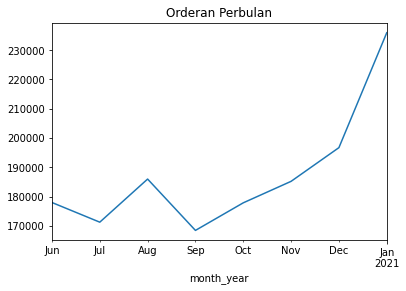

In [ ]:
# Kelompokkan data pembelian berdasarkan bulan
order_per_month = df_orders.groupby('month_year').sum()['order']

# plot jumlah order perbulan
plt.title("Orderan Perbulan")
order_per_month.plot.line()
plt.show()

## 2.3. Penjualan Item Terbanyak

In [ ]:
# Kelompokkan data berdasarkan item
most_item = df_orders.groupby('itemID').sum()

In [ ]:
# Urutkan 20 item terbanyak yang diorder
most_item = most_item['order'].sort_values(ascending = False)[:20]

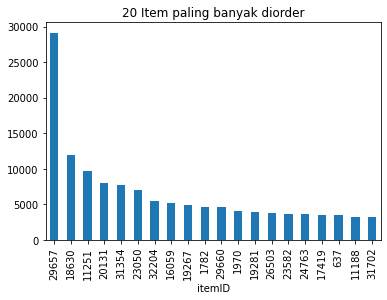

In [ ]:
# Plot item terbanyak yang diorder
plt.title("20 Item paling banyak diorder")
most_item.plot.bar()
plt.show()

#3.Preprocessing Data

## 3.1.Split Kolom Date

In [ ]:
df_orders_2 = df_orders.drop(columns = ['month_year'])

In [ ]:
# Preview Dataset
df_orders_2.head()

,date,userID,itemID,order
0,2020-06-01,38769,3477,1
1,2020-06-01,42535,30474,1
2,2020-06-01,42535,15833,1
3,2020-06-01,42535,20131,1
4,2020-06-01,42535,4325,1


In [ ]:
# Split kolom date menjadi day, month, dan year (kolom baru)
df_orders_2['day'] = pd.to_datetime(df_orders['date']).dt.day
df_orders_2['month'] = pd.to_datetime(df_orders['date']).dt.month
df_orders_2['year'] = pd.to_datetime(df_orders['date']).dt.year

In [ ]:
df_orders_2 = df_orders_2.drop(columns = ['date'])
df_orders_2

,userID,itemID,order,day,month,year
0,38769,3477,1,1,6,2020
1,42535,30474,1,1,6,2020
2,42535,15833,1,1,6,2020
3,42535,20131,1,1,6,2020
4,42535,4325,1,1,6,2020
...,...,...,...,...,...,...
1071533,22114,29567,2,31,1,2021
1071534,22114,21068,1,31,1,2021
1071535,10900,18270,1,31,1,2021
1071536,17894,31265,5,31,1,2021


## 3.2.Membuat Kolom Minggu Berdasarkan Hari

In [ ]:
# data unik pada kolom day
df_orders_2['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
# fungsi membuat hari menjadi minggu 
def dayToWeek(day):
  if(day >= 1 and day <= 7) : 
    return 1
  elif(day >= 8 and day <=14):
    return 2
  elif(day >= 15 and day <=21):
    return 3
  elif(day >= 22 and day <= 31):
    return 4
  raise Exception("Data tanggal tidak valid")

In [ ]:
# karena dalam 1 bulan kurang lebih ada tanggal 1 - 31, maka rentang ini akan dibagi menjadi 4 minggu
df_orders_2['week'] = df_orders_2['day'].apply(dayToWeek)
df_orders_2.head()

,userID,itemID,order,day,month,year,week
0,38769,3477,1,1,6,2020,1
1,42535,30474,1,1,6,2020,1
2,42535,15833,1,1,6,2020,1
3,42535,20131,1,1,6,2020,1
4,42535,4325,1,1,6,2020,1


## 3.3.Ekstrasksi Pola Pembelian

In [ ]:
# user membeli item apa yang dibeli berulang-ulang?
df_cyclical = df_orders_2[df_orders_2.duplicated(subset = ['userID', 'itemID'], keep = False)]

# Sebagai contoh misal pada userID 0
df_cyclical[(df_cyclical['userID'] == 0)].sort_values(by = 'itemID')

,userID,itemID,order,day,month,year,week
819667,0,6446,1,11,12,2020,2
978365,0,6446,1,15,1,2021,3
22146,0,20664,1,5,6,2020,1
540881,0,20664,1,9,10,2020,2
819668,0,20664,1,11,12,2020,2
709720,0,28231,1,20,11,2020,3
819666,0,28231,1,11,12,2020,2
1031088,0,28231,2,25,1,2021,4


Pada user dengan ID = 0. User ini membeli itemID = 20664 sebanyak 3x yaitu pada minggu ke 2 (2x) dan minggu ke 1 (1x). Sehingga ada kemungkinan barang harus sudah diisi kembali pada minggu ke 1 atau minggu ke 2

In [ ]:
# user membeli item apa yang tidak dilakukan berulang? (hanya 1x beli)
df_not_cyclical = df_orders_2[~df_orders_2.duplicated(subset = ['userID', 'itemID'], keep = False)]

# Sebagai contoh misal pada userID 0
df_not_cyclical[(df_not_cyclical['userID'] == 0)].sort_values(by = 'itemID')

,userID,itemID,order,day,month,year,week
390966,0,1505,1,1,9,2020,1
709719,0,9325,1,20,11,2020,3
268197,0,12468,1,3,8,2020,1
334333,0,12505,1,18,8,2020,3
1031053,0,13146,2,25,1,2021,4
268196,0,15083,1,3,8,2020,1
540880,0,26387,1,9,10,2020,2
978366,0,29956,1,15,1,2021,3
779709,0,31683,1,4,12,2020,1
779710,0,31923,1,4,12,2020,1


Pada user dengan ID = 0. User ini membeli itemID = 1505 hanya 1x sehingga kemungkinan tidak ada pola pembelian yang dapat diambil.

## 3.4.Pelabelan Data Replenishment

In [ ]:
# Membuat kolom replenishment sebagai prediksi apakah barang tertentu harus diisi lagi pada minggu keberapa berdasarkan pola user

df_cyclical['replenishment'] =  df_cyclical['week']
df_not_cyclical['replenishment'] = np.zeros(len(df_not_cyclical), dtype = 'int')
df_orders_3 = pd.concat([df_cyclical,df_not_cyclical]).sort_index()
df_orders_3

,userID,itemID,order,day,month,year,week,replenishment
0,38769,3477,1,1,6,2020,1,0
1,42535,30474,1,1,6,2020,1,0
2,42535,15833,1,1,6,2020,1,0
3,42535,20131,1,1,6,2020,1,0
4,42535,4325,1,1,6,2020,1,0
...,...,...,...,...,...,...,...,...
1071533,22114,29567,2,31,1,2021,4,0
1071534,22114,21068,1,31,1,2021,4,0
1071535,10900,18270,1,31,1,2021,4,0
1071536,17894,31265,5,31,1,2021,4,0


In [ ]:
df_orders_3['replenishment'].value_counts()

0    782810
4     90626
2     68200
3     65510
1     64392
Name: replenishment, dtype: int64

## 3.5.Klasterisasi Data Item

In [ ]:
# preview dataset item
df_items

,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories
0,22665,861,4,0,490,2,66,"[2890, 855, 3908, 3909]"
1,28640,1366,10,1,537,0,101,NaN
2,13526,1090,10,0,511,0,0,"[3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3..."
3,21399,1090,10,1,511,0,0,[3270]
4,8504,768,4,1,484,0,66,[2470]
...,...,...,...,...,...,...,...,...
32771,12036,1383,10,0,503,0,101,"[3502, 1088, 2004, 691, 3422, 2308, 308, 3688,..."
32772,22709,567,4,2,491,3,66,"[3900, 3905, 3903, 3910, 1807, 274, 1467, 914]"
32773,32322,1385,10,1,500,0,37,"[2686, 2609, 725]"
32774,19118,1113,6,2,491,0,117,"[3900, 3910, 3903, 2473, 914, 274]"


In [ ]:
# Drop kolom categories, itemID dan brand karena disini kita akan mengelompokkan item berdasarkan data feature
df_items_2 = df_items.drop(columns = ['categories', 'itemID', 'brand'])
df_items_2.head()

,feature_1,feature_2,feature_3,feature_4,feature_5
0,4,0,490,2,66
1,10,1,537,0,101
2,10,0,511,0,0
3,10,1,511,0,0
4,4,1,484,0,66


In [ ]:
# melihat info data yang akan diklaster
df_items_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32776 entries, 0 to 32775
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   feature_1  32776 non-null  int64
 1   feature_2  32776 non-null  int64
 2   feature_3  32776 non-null  int64
 3   feature_4  32776 non-null  int64
 4   feature_5  32776 non-null  int64
dtypes: int64(5)
memory usage: 1.3 MB


In [ ]:
# Normalisasi Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_items_2)
df_items_3 = scaler.transform(df_items_2)
df_items_3

array([[0.45454545, 0.        , 0.9109462 , 0.6       , 0.35078534],
       [1.        , 0.33333333, 0.99814471, 0.2       , 0.53403141],
       [1.        , 0.        , 0.94990724, 0.2       , 0.0052356 ],
       ...,
       [1.        , 0.33333333, 0.92949907, 0.2       , 0.19895288],
       [0.63636364, 0.66666667, 0.91280148, 0.2       , 0.61780105],
       [0.45454545, 1.        , 0.90166976, 0.8       , 0.08900524]])

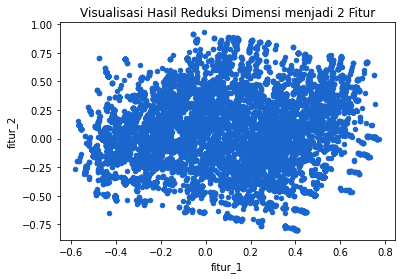

In [ ]:
# Reduksi Dimensi dengan PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_items_3)
PCA_data = pd.DataFrame(pca.transform(df_items_3), columns=(["fitur_1","fitur_2"]))
PCA_data.plot.scatter(x = 'fitur_1',y = 'fitur_2', c=np.array([0.1,0.4,0.8]).reshape(1,-1))
plt.title("Visualisasi Hasil Reduksi Dimensi menjadi 2 Fitur")
plt.show()

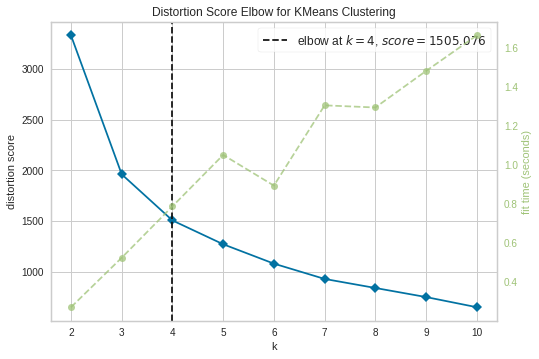

In [ ]:
# Penentuan Jumlah Klaster
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
elbowMethod = KElbowVisualizer(KMeans(), k=10, metric = "distortion")
elbowMethod.fit(PCA_data)
elbowMethod.show()
plt.show()

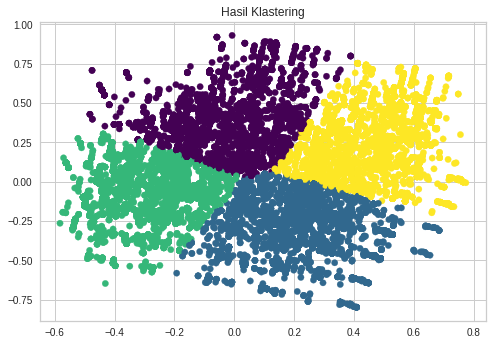

In [ ]:
# Hasil Klaster
KM = KMeans(n_clusters=4)
predictKM = KM.fit_predict(PCA_data)
PCA_data["clusters"] = predictKM

plt.title("Hasil Klastering")
plt.scatter(PCA_data["fitur_1"],PCA_data["fitur_2"], s=40, c=PCA_data["clusters"], marker='o',cmap = 'viridis')
plt.show()

In [ ]:
# Assign hasil klaster ke data item
df_items_klaster = df_items.drop(columns = ['categories']).assign(item_cluster = PCA_data["clusters"])
df_items_klaster.head()

,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,item_cluster
0,22665,861,4,0,490,2,66,0
1,28640,1366,10,1,537,0,101,1
2,13526,1090,10,0,511,0,0,2
3,21399,1090,10,1,511,0,0,2
4,8504,768,4,1,484,0,66,2


## 3.6.Penggabungan Data Order dan Data Item

In [ ]:
# menggambungkan data order dan data item hasil klaster
df_orders_items = pd.merge(df_orders_3, df_items_klaster, on = "itemID")
df_orders_items.head()

,userID,itemID,order,day,month,year,week,replenishment,brand,feature_1,feature_2,feature_3,feature_4,feature_5,item_cluster
0,38769,3477,1,1,6,2020,1,0,186,6,0,196,0,45,0
1,23570,3477,1,1,6,2020,1,0,186,6,0,196,0,45,0
2,23495,3477,1,1,6,2020,1,0,186,6,0,196,0,45,0
3,26073,3477,1,1,6,2020,1,0,186,6,0,196,0,45,0
4,34302,3477,1,1,6,2020,1,0,186,6,0,196,0,45,0


## 3.7.Feature Selection

In [ ]:
# drop kolom order, day, month, year dan week
df_orders_items_2 = df_orders_items.drop(columns = ['order', 'day', 'month', 'year', 'week'])
df_orders_items_2.head()

,userID,itemID,replenishment,brand,feature_1,feature_2,feature_3,feature_4,feature_5,item_cluster
0,38769,3477,0,186,6,0,196,0,45,0
1,23570,3477,0,186,6,0,196,0,45,0
2,23495,3477,0,186,6,0,196,0,45,0
3,26073,3477,0,186,6,0,196,0,45,0
4,34302,3477,0,186,6,0,196,0,45,0


# 4.Pembangunan Model Klasifikasi

## 4.1.Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = df_orders_items_2.drop(columns=['replenishment'], axis=1)
y = df_orders_items_2[['replenishment']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=120)


## 4.2.Pembangunan Model

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
# Train untuk tiap Algoritma
scores = []
models = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(),DecisionTreeClassifier()]
models_name = ["Naive Bayes", "Logistic Regression", "KNN", "Decision Tree"] 
iterator = 0

for model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  scores.append({
      "Model" : models_name[iterator],
      "Accuracy" : accuracy_score(y_test, y_pred),
      "F1 Score" : f1_score(y_test, y_pred,average = 'weighted'),
      "Recall" : recall_score(y_test, y_pred,average = 'weighted'),
      "Precision" : precision_score(y_test, y_pred,average = 'weighted')
  })
  iterator += 1

In [ ]:
result = pd.DataFrame(scores, columns = ['Model', 'Accuracy','F1 Score', 'Precision', 'Recall']).set_index('Model')
result

,Accuracy,F1 Score,Precision,Recall
Model,,,,
Naive Bayes,0.730500,0.616735,0.533630,0.730500
Logistic Regression,0.730500,0.616735,0.533630,0.730500
KNN,0.701386,0.639609,0.600946,0.701386
Decision Tree,0.678313,0.704027,0.735588,0.678313


## 4.3.Prediksi Data Submission

In [ ]:
# preview dataset submission
df_submission.head()

,userID,itemID,prediction
0,0,20664,NaN
1,0,28231,NaN
2,13,2690,NaN
3,15,1299,NaN
4,15,20968,NaN


In [ ]:
# menggabungkan data item pada data submission 
df_submission_extended = pd.merge(df_submission, df_items_klaster, on = "itemID")
df_submission_extended = df_submission_extended[np.concatenate((['userID'], df_items_klaster.columns,['prediction']))]
df_submission_extended

,userID,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,item_cluster,prediction
0,0,20664,408,4,0,284,0,66,0,NaN
1,23363,20664,408,4,0,284,0,66,0,NaN
2,0,28231,193,4,3,468,3,108,1,NaN
3,13,2690,406,4,3,491,0,66,2,NaN
4,15,1299,1056,4,0,474,-1,108,1,NaN
...,...,...,...,...,...,...,...,...,...,...
9995,46049,17984,449,6,0,207,3,45,0,NaN
9996,46069,29992,280,4,0,484,0,44,2,NaN
9997,46117,8847,143,6,1,46,0,69,0,NaN
9998,46124,19677,1006,4,0,491,3,154,3,NaN


In [ ]:
# prediksi data submission dengan decision tree classifier
df_submission_extended['prediction'] = models[3].predict(df_submission_extended.drop(columns = 'prediction'))
df_submission_extended.head()

,userID,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,item_cluster,prediction
0,0,20664,408,4,0,284,0,66,0,1
1,23363,20664,408,4,0,284,0,66,0,2
2,0,28231,193,4,3,468,3,108,1,2
3,13,2690,406,4,3,491,0,66,2,4
4,15,1299,1056,4,0,474,-1,108,1,4


In [ ]:
df_submission_extended['prediction'].value_counts()

1    3419
2    2603
4    1923
3    1729
0     326
Name: prediction, dtype: int64

In [ ]:
df_submission['prediction'] = df_submission_extended['prediction']
df_submission.head()

,userID,itemID,prediction
0,0,20664,1
1,0,28231,2
2,13,2690,2
3,15,1299,4
4,15,20968,4


In [ ]:
# Melihat kesesuaian hasil prediksi dengan pola pembelian user pada periode sebelumnya (cth userID = 15)
df_cyclical[(df_cyclical['userID'] == 15) & ((df_cyclical['itemID'] == 1299) | (df_cyclical['itemID'] == 20968))].sort_values(by = 'itemID')

,userID,itemID,order,day,month,year,week,replenishment
420602,15,1299,1,9,9,2020,2,2
756052,15,1299,1,29,11,2020,4,4
884004,15,1299,1,26,12,2020,4,4
976627,15,1299,1,14,1,2021,2,2
538845,15,20968,1,8,10,2020,2,2
756049,15,20968,1,29,11,2020,4,4
884005,15,20968,1,26,12,2020,4,4
1036486,15,20968,1,25,1,2021,4,4


In [ ]:
# Eksport dataset submission
df_submission.to_csv("submission.csv", index=False)